# Twitter Sentiment Analysis

## Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

plt.style.use(style='ggplot')

import wordninja
import re

In [2]:
desired_cols = [
    'gender',
    'created',
    'text',
    'tweet_count',
    'tweet_id'
]

df = pd.read_csv(
    'gender-classifier-DFE-791531.csv',
    usecols=desired_cols,
    parse_dates=['created'],
    date_format='%m/%d/%y %H:%M',
    encoding='ISO-8859-1'
)

df.head(5)

,gender,created,text,tweet_count,tweet_id
0,male,2013-12-05 01:48:00,Robbie E Responds To Critics After Win Against...,110964,6.587300e+17
1,male,2012-10-01 13:51:00,ÛÏIt felt like they were my friends and I was...,7471,6.587300e+17
2,male,2014-11-28 11:30:00,i absolutely adore when louis starts the songs...,5617,6.587300e+17
3,male,2009-06-11 22:39:00,Hi @JordanSpieth - Looking at the url - do you...,1693,6.587300e+17
4,female,2014-04-16 13:23:00,Watching Neighbours on Sky+ catching up with t...,31462,6.587300e+17


## Data Cleaning

### Assign unique id to tweets

In [3]:
df['tweet_id'] = df.index

### Remove hyperlinks and usertags

In [4]:
df['text'].values[0]

'Robbie E Responds To Critics After Win Against Eddie Edwards In The #WorldTitleSeries https://t.co/NSybBmVjKZ'

In [5]:
df['content lower'] = df['text'].str.lower()

In [6]:
url_regex = r'(https:\/\/www\.|http:\/\/www\.|https:\/\/|http:\/\/)?[a-zA-Z]{1,}(\.[a-zA-Z]{2,})(\.[a-zA-Z]{2,})?\/[a-zA-Z0-9]{2,}|((https:\/\/www\.|http:\/\/www\.|https:\/\/|http:\/\/)?[a-zA-Z]{2,}(\.[a-zA-Z]{2,})(\.[a-zA-Z]{2,})?)|(https:\/\/www\.|http:\/\/www\.|https:\/\/|http:\/\/)?[a-zA-Z0-9]{2,}\.[a-zA-Z0-9]{2,}\.[a-zA-Z0-9]{2,}(\.[a-zA-Z0-9]{2,})?'
df['content no links'] = df['content lower'].str.replace(url_regex, '', regex=True, flags=re.MULTILINE).str.strip()

In [7]:
def explode(concat_word: str) -> str:
    return ' '.join(wordninja.split(concat_word))

hashtag_regex = r'#([\w]+)'

df['content context aware'] = df['content no links'].apply(
    lambda text: re.sub(hashtag_regex, lambda m: explode(m.group(1)), text)
)
df['content no context'] = df['content no links'].str.replace(hashtag_regex, '', regex=True, flags=re.MULTILINE).str.strip()

### Removing Emojis (because of improper uses)

In [8]:
df['content context aware clean'] = df['content context aware'].str.encode('ascii', 'ignore').str.decode('ascii')
df['content no context clean'] = df['content no context'].str.encode('ascii', 'ignore').str.decode('ascii')

In [9]:
df = df.drop(axis='columns', columns=['content lower', 'content no links', 'content context aware', 'content no context'])

## VADER Seniment Scoring

### Setup

In [ ]:
# NLTK setup
nltk.download('vader_lexicon')
sentiment_analyzer = SentimentIntensityAnalyzer()

### Scoring

In [11]:
scores = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['content no context clean']
    tweet_id = row['tweet_id']
    scores[tweet_id] = sentiment_analyzer.polarity_scores(text)

df['VADER no context'] = pd.DataFrame(scores).T['compound']

  0%|          | 0/20050 [00:00<?, ?it/s]

In [12]:
scores = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['content context aware clean']
    tweet_id = row['tweet_id']
    scores[tweet_id] = sentiment_analyzer.polarity_scores(text)

df['VADER context aware'] = pd.DataFrame(scores).T['compound']

  0%|          | 0/20050 [00:00<?, ?it/s]

In [99]:
noticeable_diffs = df[ (df['VADER no context'] - df['VADER context aware']).abs() > 0.5 ]
noticeable_diffs[['text', 'VADER no context', 'VADER context aware']]

,text,VADER no context,VADER context aware
46,@MarkHicks1204 I went to the wrong Nandos but ...,-0.2617,0.5267
95,The accumulation of rake marks:SNIP #Blackfish...,-0.0258,0.4939
315,#massimolandi #newyork #newyorkcity #nyc The W...,0.0000,-0.5267
347,"""All of the computer hacking techniques descri...",0.0000,0.5106
360,https://t.co/1yq5cEd08Q One of the greatest un...,0.6696,-0.1007
...,...,...,...
19313,Join me on #WowApp ÛÒ #PowerOfSharing to conn...,0.2960,0.8316
19332,Check out @FightCRC (https://t.co/OLmwalljPO) ...,0.0000,-0.6597
19372,#Cool as a #Cucumber #Water #Bottle\nStay #coo...,0.0000,0.7430
19576,#ShoutYourAbortion and #ladypartsjustice let's...,0.0000,0.5267


### Classification

In [53]:
def vader_classification(compound: float) -> str:
    if compound > 0.06:
        return 'positive'
    elif compound < -0.06:
        return 'negative'
    return 'neutral'

df['VADER context aware sentiment'] = df['VADER context aware'].apply(vader_classification)
df['VADER no context sentiment'] = df['VADER no context'].apply(vader_classification)

### Distribution Analysis

<Axes: title={'center': 'VADER context aware sentiment by gender'}, xlabel='Gender', ylabel='Count'>

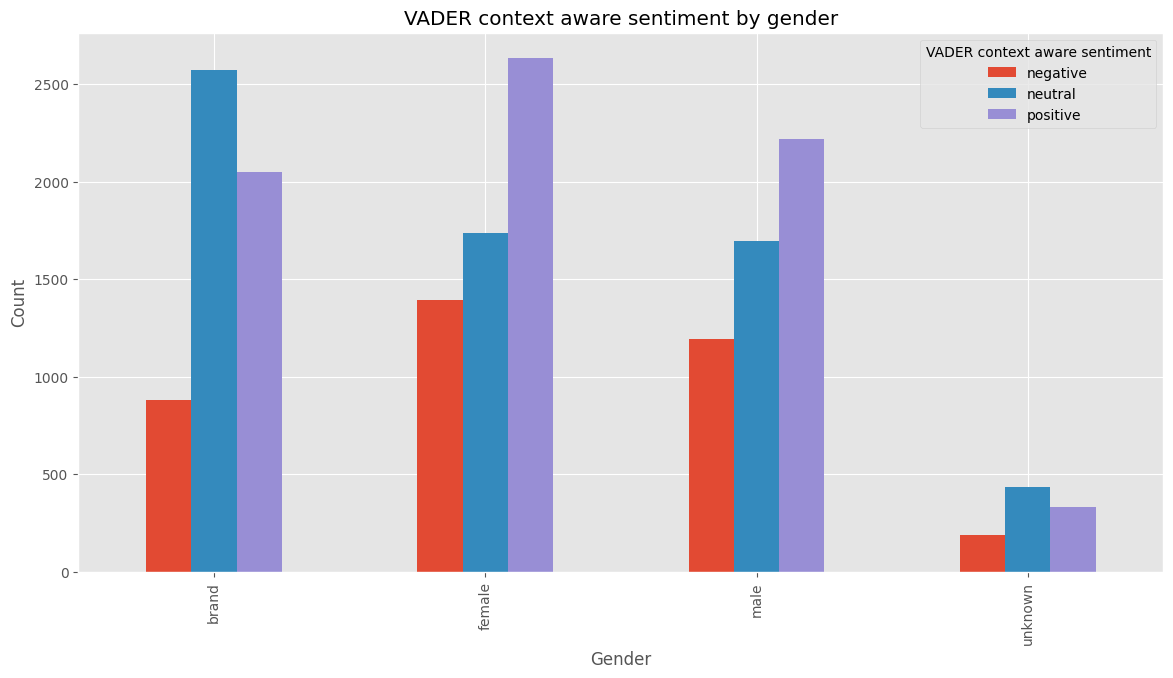

In [74]:
# @title Tweet sentiment by gender

fig, ax = plt.subplots(figsize=(14, 7))

sentiment_by_gender = df.groupby(['gender', 'VADER context aware sentiment'])\
    .size()\
    .unstack(fill_value=0)

sentiment_by_gender.plot(
    kind='bar',
    ax=ax,
    title='VADER context aware sentiment by gender',
    xlabel='Gender',
    ylabel='Count'
)

(0.0, 20000.0)

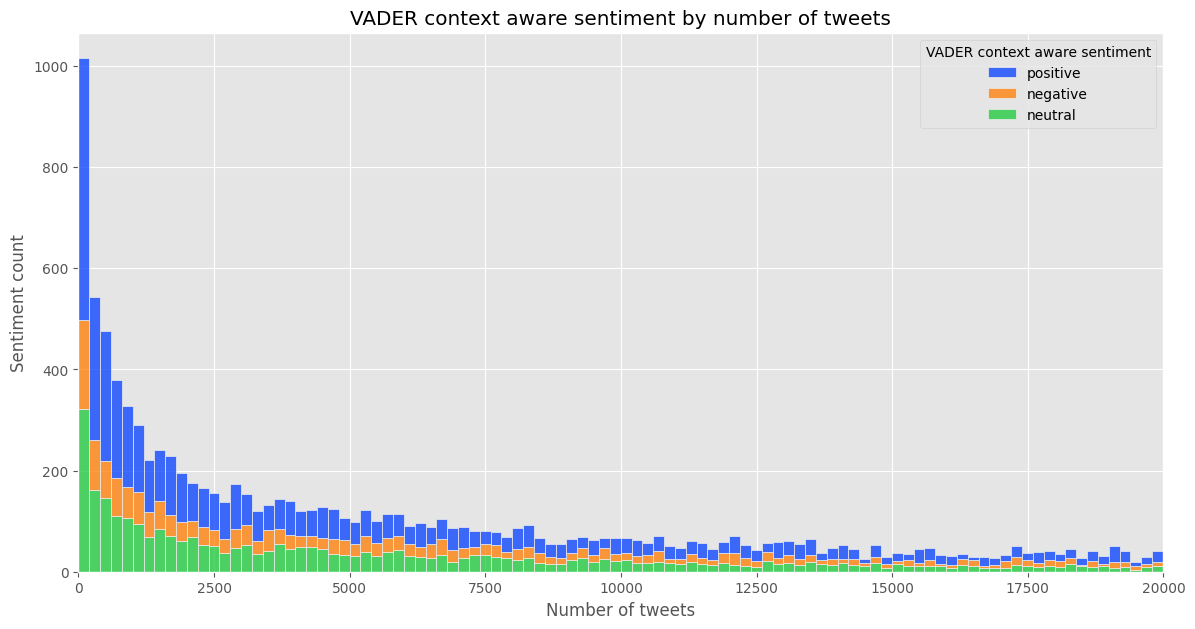

In [79]:
# @title Tweet sentiment by number of tweets

fig, ax = plt.subplots(figsize=(14, 7))

plot_data = df[ df['tweet_count'] < 20000 ]

sns.histplot(
    data=plot_data,
    x='tweet_count',
    hue='VADER context aware sentiment',
    multiple='stack',
    palette='bright',
    ax=ax,
    bins=100
)

ax.set_title('VADER context aware sentiment by number of tweets')
ax.set_xlabel('Number of tweets')
ax.set_ylabel('Sentiment count')

ax.set_xlim((0, 20000))

Text(0, 0.5, '')

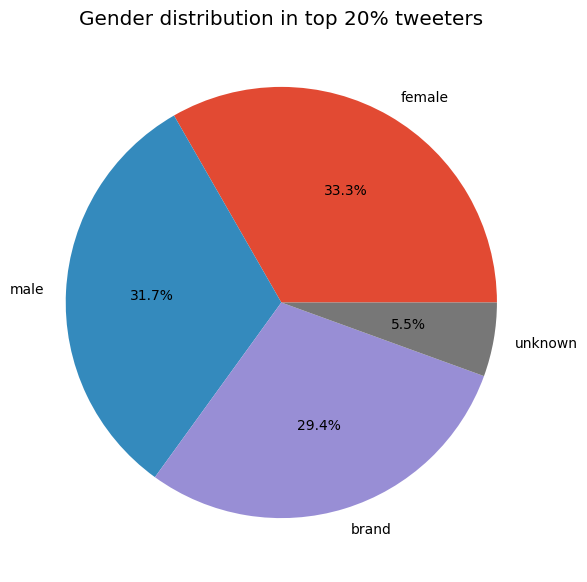

In [83]:
# @title Gender distribution in top 20% tweeters

fig, ax = plt.subplots(figsize=(14, 7))

plot_data = df.sort_values('tweet_count').head(int(len(df) * 0.2))

plot_data['gender'].value_counts()\
    .plot(
        kind='pie',
        autopct='%1.1f%%',
        ax=ax,
        title='Gender distribution in top 20% tweeters'
  )
ax.set_ylabel('')

(13879.0, 16709.0)

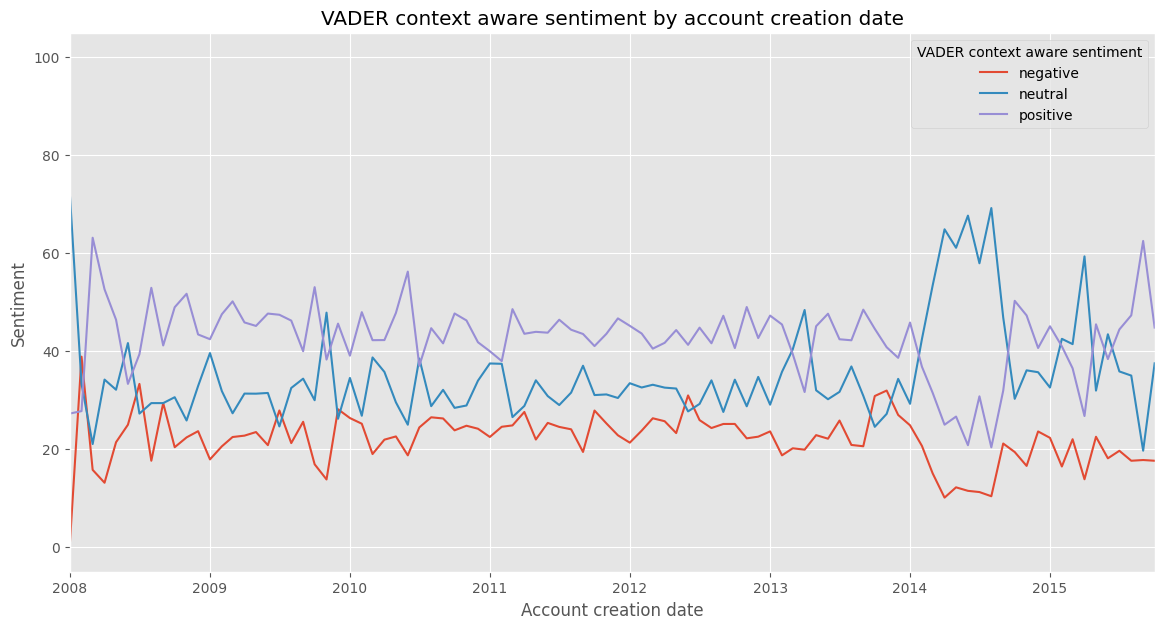

In [85]:
# @title VADER context aware sentiment by account creation date

sentiment_by_account_creation = df.groupby([
    pd.Grouper(key='created', freq='MS'),
    'VADER context aware sentiment'
]).size().reset_index(name='count')


pivot = sentiment_by_account_creation.pivot_table(index='created', columns='VADER context aware sentiment', values='count', fill_value=0)
sentiment_by_account_creation = pivot.reset_index().melt(id_vars='created', value_name='count', var_name='VADER context aware sentiment')
total_tweets_per_month = sentiment_by_account_creation.groupby('created')['count'].transform('sum')
sentiment_by_account_creation['percentage'] = (sentiment_by_account_creation['count'] / total_tweets_per_month) * 100

fig, ax = plt.subplots(figsize=(14, 7))

sns.lineplot(
    data=sentiment_by_account_creation,
    x='created',
    y='percentage',
    hue='VADER context aware sentiment',
    ax=ax,
)

ax.set_title('VADER context aware sentiment by account creation date')
ax.set_xlabel('Account creation date')
ax.set_ylabel('Sentiment')

start_date = pd.Timestamp('2008-01-01')
end_date = sentiment_by_account_creation['created'].max()
plt.xlim(start_date, end_date)


## BERTweet Sentiment Scoring

### Setup

In [58]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
import torch

In [59]:
MODEL = f"finiteautomata/bertweet-base-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


In [60]:
MAX_MODEL_INPUT_LEN = tokenizer.model_max_length
df = df[ df['content context aware clean'].str.len() < MAX_MODEL_INPUT_LEN ]

### Scoring and Classification

In [61]:
# batch size for processing
batch_size = 16
labels = ['positive', 'neutral', 'negative']

scores = {}

# process text in batches
for start in tqdm(range(0, len(df), batch_size)):
    end = start + batch_size
    batch_df = df[start:end]

    # batch tokenization
    texts = batch_df['content context aware clean'].tolist()
    encoded_batch = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)

    # disable gradient calculation to speed up inference
    with torch.no_grad():
        outputs = model(**encoded_batch)

    # move logits to CPU and convert to list
    batch_logits = outputs.logits

    # apply softmax to normalize outputs
    # dim=-1 => apply softmax along the last dimension (score dimension)
    batch_probabilities = torch.softmax(batch_logits, dim=-1)

    # convert probabilities to labels
    predicted_indices = torch.argmax(batch_probabilities, dim=-1)
    predicted_labels = [labels[idx] for idx in predicted_indices]

    for i, tweet_id in enumerate(batch_df['tweet_id']):
        scores[tweet_id] = {
            'probabilities': batch_probabilities[i].numpy(),
            'label': predicted_labels[i]
        }

  0%|          | 0/1089 [00:00<?, ?it/s]

In [86]:
df['BERTweet sentiment'] = df['tweet_id'].map(lambda x: scores[x]['label'])

### Distribution Analysis

<Axes: title={'center': 'BERTweet sentiment by gender'}, xlabel='Gender', ylabel='Count'>

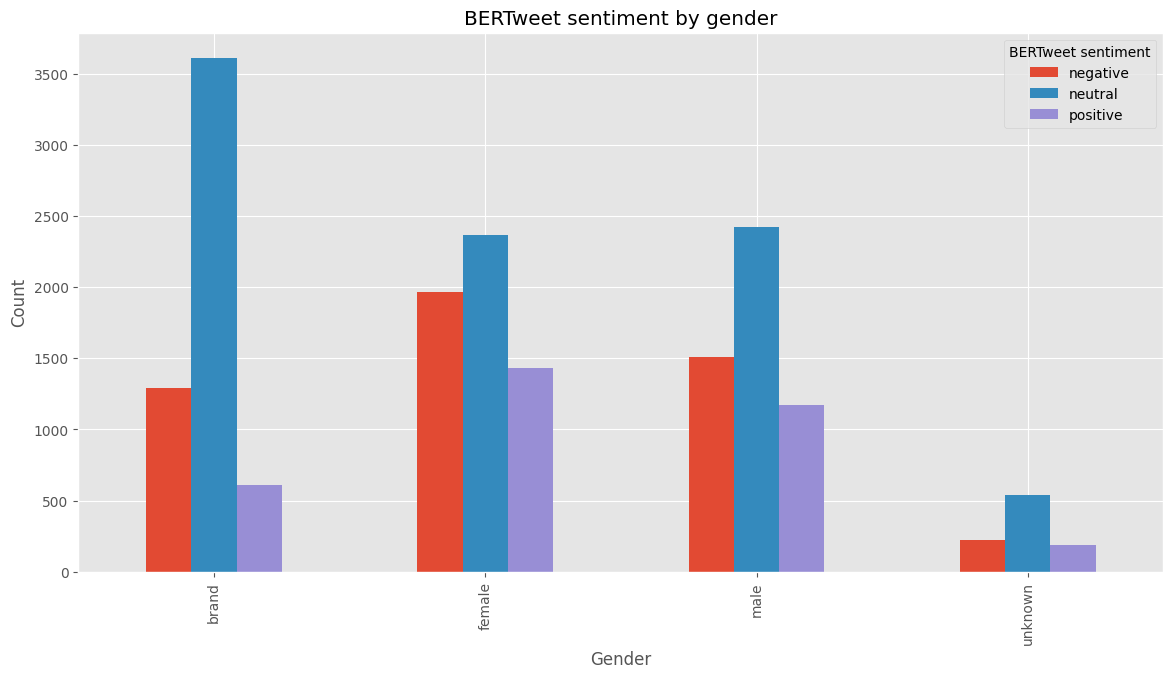

In [88]:
# @title Tweet sentiment by gender

fig, ax = plt.subplots(figsize=(14, 7))

sentiment_by_gender = df.groupby(['gender', 'BERTweet sentiment'])\
    .size()\
    .unstack(fill_value=0)

sentiment_by_gender.plot(
    kind='bar',
    ax=ax,
    title='BERTweet sentiment by gender',
    xlabel='Gender',
    ylabel='Count'
)

(0.0, 20000.0)

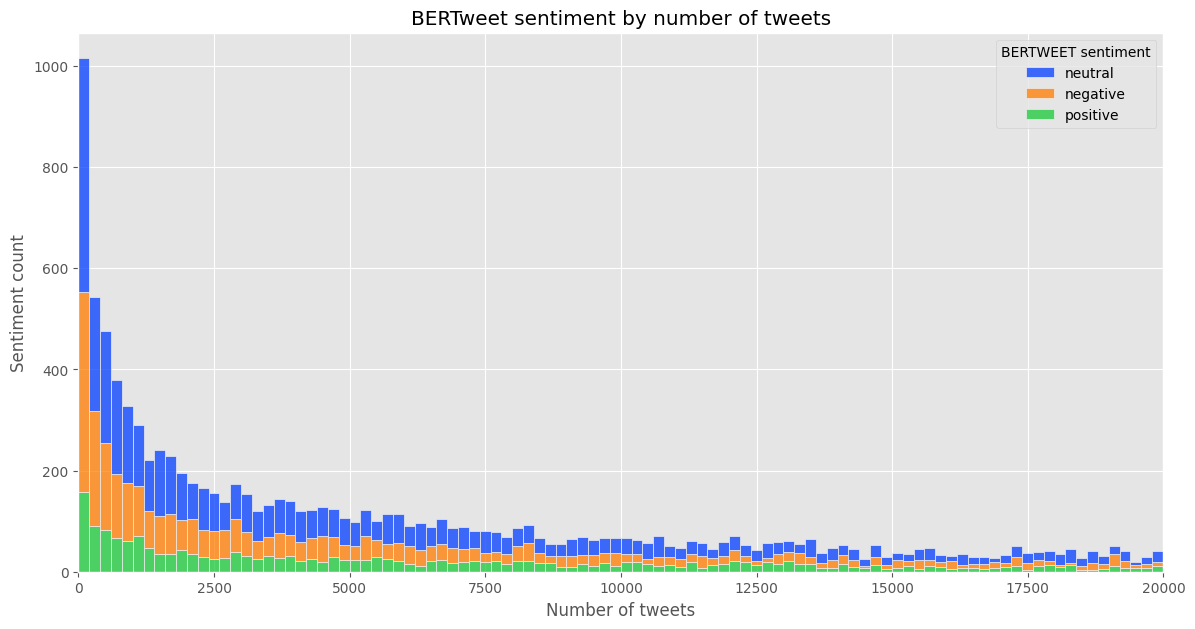

In [89]:
# @title Tweet sentiment by number of tweets

fig, ax = plt.subplots(figsize=(14, 7))

plot_data = df[ df['tweet_count'] < 20000 ]

sns.histplot(
    data=plot_data,
    x='tweet_count',
    hue='BERTweet sentiment',
    multiple='stack',
    palette='bright',
    ax=ax,
    bins=100
)

ax.set_title('BERTweet sentiment by number of tweets')
ax.set_xlabel('Number of tweets')
ax.set_ylabel('Sentiment count')

ax.set_xlim((0, 20000))

## How off were we?

In [97]:
vader_context_aware_accuracy = (df['VADER context aware sentiment'] == df['BERTweet sentiment']).sum() * 100 / len(df)
vader_no_context_accuracy = (df['VADER no context sentiment'] == df['BERTweet sentiment']).sum() * 100 / len(df)

In [98]:
print(vader_context_aware_accuracy)
print(vader_no_context_accuracy)

34.70372071658245
35.73725310059715


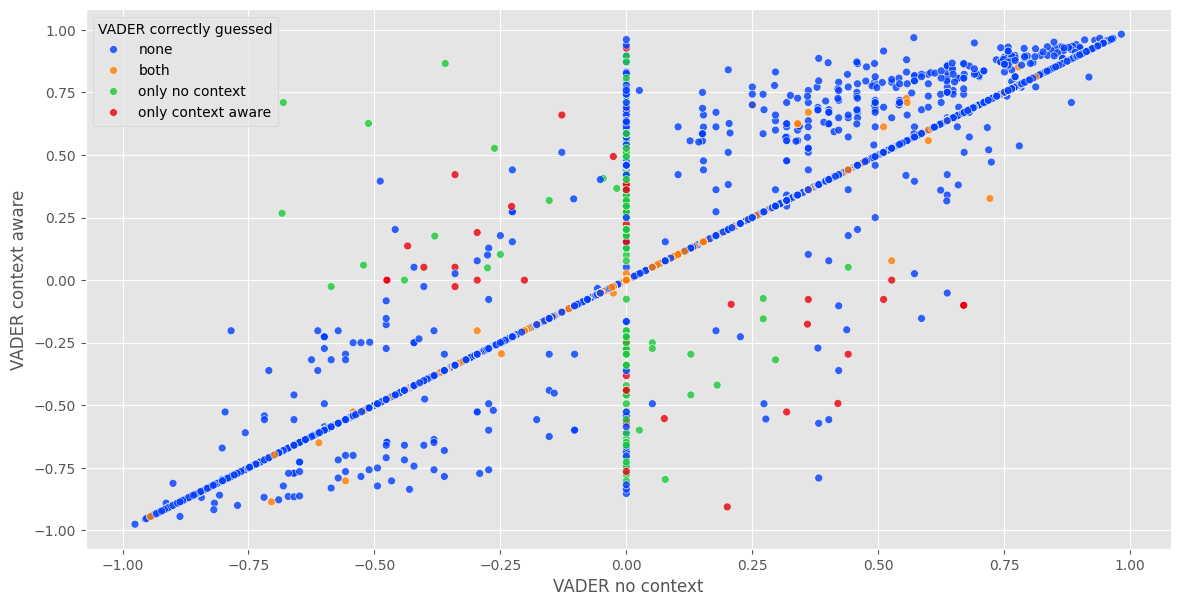

In [96]:
def guess_outcome(no_context, context_aware):
  if no_context and context_aware:
    return 'both'
  elif no_context:
    return 'only no context'
  elif context_aware:
    return 'only context aware'
  return 'none'


vader_no_context_correct_guesses = df['VADER no context sentiment'] == df['BERTweet sentiment']
vader_context_aware_correct_guesses = df['VADER context aware sentiment'] == df['BERTweet sentiment']
df['VADER correctly guessed'] = [
    guess_outcome(a, b) for a, b in zip(vader_no_context_correct_guesses, vader_context_aware_correct_guesses)
]

fig, ax = plt.subplots(figsize=(14, 7))

sns.scatterplot(
    data=df,
    x='VADER no context',
    y='VADER context aware',
    hue='VADER correctly guessed',
    palette='bright',
    s=32,
    alpha=.8,
    ax=ax
)
plt.gca().spines[['top', 'right',]].set_visible(False)